In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf

In [25]:
release_zone = "test_1500"
number_particles = 100000
start_year = 2009
start_month = 5
start_day = 1
runtime_in_days = 42

In [26]:
#SIGMA=xr.open_dataset('../data/config/ROMS/sigma2depth_parent.nc')
INALT_mask=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_mfdataset(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS119/Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc',concat_dim="traj",
    combine="nested",) #INALT20.L46-KFS119
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(100000, 44), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [4]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT.rename({'lat','lon'})
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

In [5]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [6]:
release_locations = load_release_locations(release_locations_file = "../../data/config/test_stations.csv")
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 1500.0)

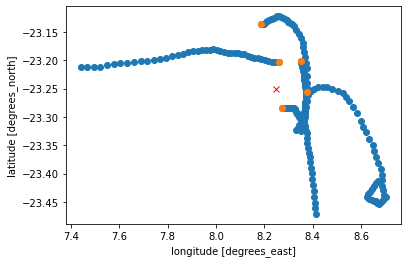

In [7]:
particle_ds.isel(traj=slice(None,None,20000)).plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0,traj=slice(None,None,20000)).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

In [27]:
depth200 = particle_ds.where((particle_ds.z>200) & (particle_ds.z<1500),drop=True)

In [28]:
traj_plot = depth200.isel(traj=slice(10,30), obs=slice(0,7,1))
start = traj_plot.isel(obs=0)
traj_plot

<xarray.Dataset>
Dimensions:     (traj: 20, obs: 7)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(20, 7), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [21]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

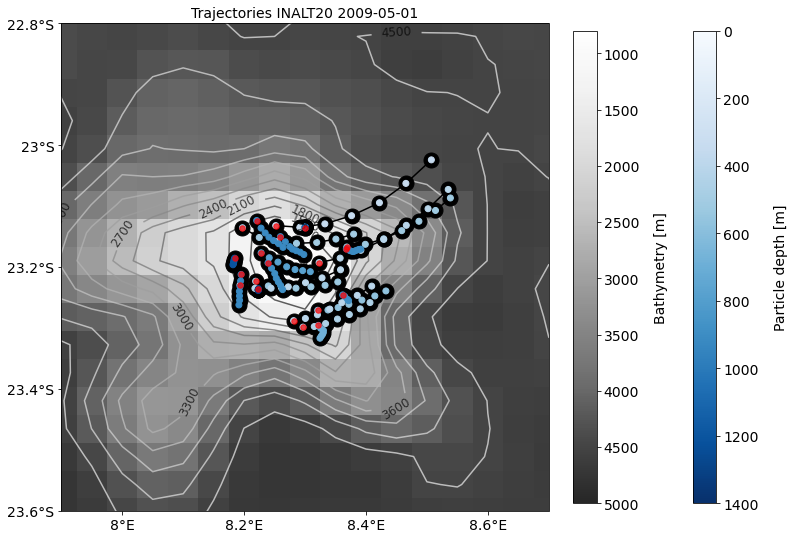

In [35]:
fig, ax = plt.subplots(1,1,figsize=(11,10),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([7.9,8.7,
               -23.6,-22.8], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,s=30,color='red',alpha=0.7)
#ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',vmin=0,vmax=1400)
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=15,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
#cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
#c=ax.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #ROMS
c=ax.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#,levels=22,
             alpha=0.85,zorder=0,cmap='Greys') #INALT
c2=fig.colorbar(c,shrink=0.662)
c2.ax.invert_yaxis()
sc.figure.axes[2].tick_params(axis="y", labelsize=14)
c2.ax.set_ylabel('Bathymetry [m]',fontsize=14)
c2.ax.get_yaxis().labelpad = 15
c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,levels=[900,1200,1500,1800,2100,2400,2700,3000,3300,3600,3900,4200,4500,4800],
             alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=12,fmt=fmt, colors= 'black')
#ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([8,8.2,8.4,8.6])
ax.set_xticklabels(['8°E','8.2°E','8.4°E','8.6°E'],fontsize=14, family='Arial')
ax.set_yticks([-23.6,-23.4,-23.2,-23,-22.8])
ax.set_yticklabels(['23.6°S','23.4°S','23.2°S','23°S','22.8°S'],fontsize=14, family='Arial')

ax.set_title(f'Trajectories INALT20 {start_year:04d}-{start_month:02d}-{start_day:02d}', fontsize = 14)
plt.savefig('INALT20-trajectories.png')
plt.show()

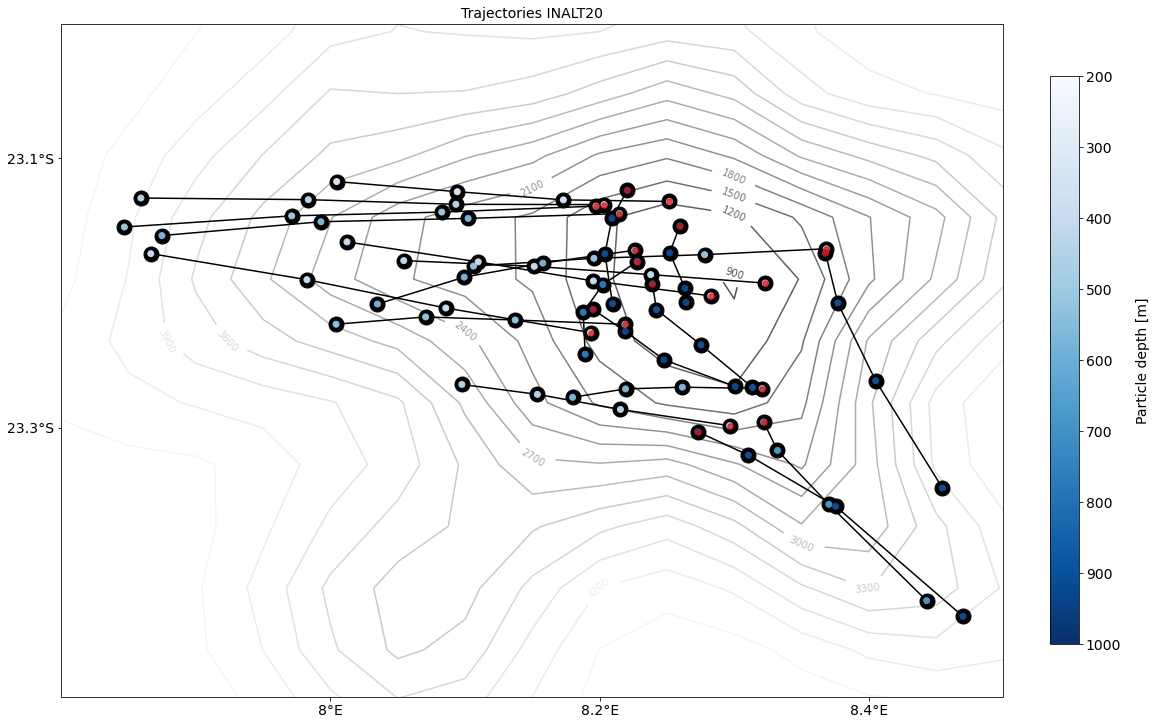

In [13]:
fig, ax = plt.subplots(1,1,figsize=(16,12),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([7.8,8.5,
               -23.5,-23.], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,s=30,color='red',alpha=0.7)
#ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',vmin=200,vmax=1000)
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=15,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
#cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
#c=ax.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #ROMS
c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,levels=22,
             alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([8,8.2,8.4])
ax.set_xticklabels(['8°E','8.2°E','8.4°E'],fontsize=14, family='Arial')
ax.set_yticks([-23.3,-23.1])
ax.set_yticklabels(['23.3°S','23.1°S'],fontsize=14, family='Arial')

ax.set_title('Trajectories INALT20', fontsize = 14)

plt.show()

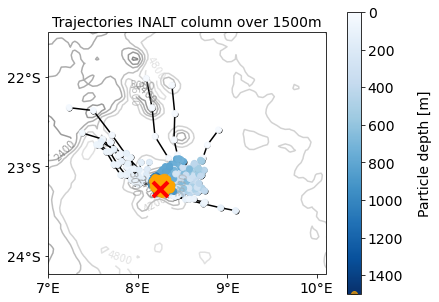

In [22]:
fig, ax = plt.subplots(1,1,figsize=(6,6),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([7,10.1,
               -24.2,-21.5], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)
ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',vmin=0,vmax=1500)
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
#c=ax.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #ROMS
c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],topo_INALT,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
ax.set_yticks([-22,-23.,-24])
ax.set_yticklabels(['22°S','23°S','24°S'],fontsize=14, family='Arial')
ax.set_title('Trajectories INALT column over 1500m', fontsize = 14)

plt.show()

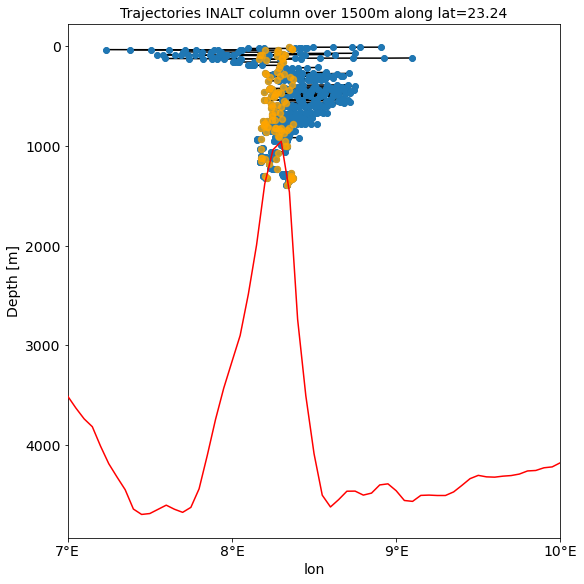

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True,
                      )


#start points
ax.scatter(start['lon'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['z'].T, zorder=2)#,c=traj_plot['z'].T,cmap='Blues')
ax.plot(traj_plot['lon'].T, traj_plot['z'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#topography lines
topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(bathymodiolus_lon-3,
                         bathymodiolus_lon+2,None)).plot(zorder=3, color='red')

#labels
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
ax.set_xlabel('lon',fontsize=14, family='Arial')
ax.set_ylabel('Depth [m]',fontsize=14, family='Arial')
ax.set_yticks([0,1000,2000,3000,4000])
ax.set_yticklabels(['0','1000','2000','3000','4000'],fontsize=14, family='Arial')

ax.set_title('Trajectories INALT column over 1500m along lat=23.24', fontsize = 14)
ax.invert_yaxis()
ax.set_xlim([7,10])
plt.show()

In [14]:
topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(bathymodiolus_lon-3,
                         bathymodiolus_lon+1,None)).min()

<xarray.DataArray ()>
array(953.4461184)
Coordinates:
    lat      float32 -23.24

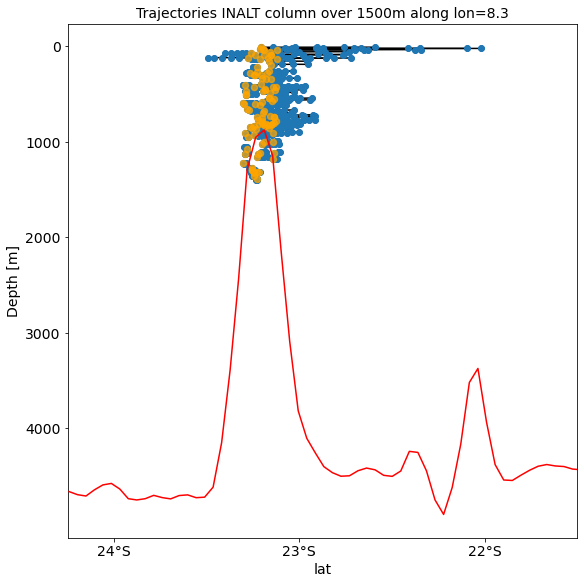

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True,
                      )


#start points
ax.scatter(start['lat'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot['lat'].T, traj_plot['z'].T, zorder=2)#,c=traj_plot['z'].T,cmap='Blues')
ax.plot(traj_plot['lat'].T, traj_plot['z'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#topography lines
topo_INALT.isel(lon=166).sel( #8.3
               lat=slice(bathymodiolus_lat-1,
                         bathymodiolus_lat+1.9,None)).plot(zorder=3, color='red')

#labels
ax.set_xticks([-24,-23,-22,])
ax.set_xticklabels(['24°S','23°S','22°S'],fontsize=14, family='Arial')
ax.set_xlabel('lat',fontsize=14, family='Arial')
ax.set_ylabel('Depth [m]',fontsize=14, family='Arial')
ax.set_yticks([0,1000,2000,3000,4000])
ax.set_yticklabels(['0','1000','2000','3000','4000'],fontsize=14, family='Arial')

ax.set_title('Trajectories INALT column over 1500m along lon=8.3', fontsize = 14)
ax.invert_yaxis()
ax.set_xlim([-24.25,-21.5])

plt.show()

In [16]:
a=particle_ds.where(topo_INALT-100<particle_ds.isel(obs=0).z)

MemoryError: Unable to allocate 4.96 TiB for an array with shape (100000, 46, 409, 362) and data type float64